In [1]:
!pip install torch transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [2]:
!apt-get update && apt-get install -y libaio-dev


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,665 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,721 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,930 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubun

In [3]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.8 MB/s eta 0:00:00


In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from datasets import load_dataset, Audio
import evaluate
from tqdm import tqdm
import numpy as np

2025-05-14 15:10:34.223161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747235434.412203      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747235434.461696      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
MODEL_PATH = "HoaDoan1710/checkpoint-whisper-14525"
BASE_MODEL = "openai/whisper-medium"  
DATASET_NAME = "google/fleurs"
LANGUAGE = "vi_vn"
SPLIT = "train"  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
OUTPUT_DIR = "/kaggle/working"

In [6]:
print("📂 Loading dataset...")
dataset = load_dataset(DATASET_NAME, LANGUAGE, split=SPLIT, trust_remote_code=True)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

📂 Loading dataset...


README.md:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

fleurs.py:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

train.tar.gz:   0%|          | 0.00/1.61G [00:00<?, ?B/s]

dev.tar.gz:   0%|          | 0.00/215M [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/544M [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

dev.tsv:   0%|          | 0.00/247k [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/614k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
print("🔄 Loading models...")
processor = WhisperProcessor.from_pretrained("hkab/whisper-base-vietnamese-finetuned")

print("Loading base model...")
base_model = WhisperForConditionalGeneration.from_pretrained(BASE_MODEL).to(DEVICE)
base_model.config.forced_decoder_ids = None

print("Loading finetuned model...")
finetuned_model = WhisperForConditionalGeneration.from_pretrained(MODEL_PATH).to(DEVICE)
finetuned_model.config.forced_decoder_ids = None

🔄 Loading models...


preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

Loading base model...


config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

Loading finetuned model...


config.json:   0%|          | 0.00/2.29k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [8]:
def evaluate_batch(batch, model, processor):
    predictions = []
    for audio_data in batch["audio"]:
        inputs = processor(
            audio=audio_data["array"],  
            sampling_rate=16000,
            return_tensors="pt"
        ).to(DEVICE)
        
        with torch.no_grad():
            outputs = model.generate(input_features=inputs.input_features)
        
        predictions.append(processor.batch_decode(outputs, skip_special_tokens=True)[0])
    
    return {"predictions": predictions}

In [9]:
print("🚀 Starting full evaluation...")
metrics = {
    "base_wer": [],
    "base_cer": [],
    "finetuned_wer": [],
    "finetuned_cer": []
}

wer = evaluate.load("wer")
cer = evaluate.load("cer")

🚀 Starting full evaluation...


In [10]:
for i in tqdm(range(0, len(dataset), BATCH_SIZE), desc="Processing batches"):
    batch = dataset[i:i+BATCH_SIZE]
    
    base_results = evaluate_batch(batch, base_model, processor)
    metrics["base_wer"].append(wer.compute(
        predictions=base_results["predictions"],
        references=batch["transcription"]
    ))
    metrics["base_cer"].append(cer.compute(
        predictions=base_results["predictions"],
        references=batch["transcription"]
    ))
    
    finetuned_results = evaluate_batch(batch, finetuned_model, processor)
    metrics["finetuned_wer"].append(wer.compute(
        predictions=finetuned_results["predictions"],
        references=batch["transcription"]
    ))
    metrics["finetuned_cer"].append(cer.compute(
        predictions=finetuned_results["predictions"],
        references=batch["transcription"]
    ))


Processing batches:   0%|          | 0/375 [00:00<?, ?it/s]Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Processing batches: 100%|██████████| 375/375 [2:37:06<00:00, 25.14s/it]


In [11]:
final_metrics = {
    "base_wer": np.mean(metrics["base_wer"]),
    "base_cer": np.mean(metrics["base_cer"]),
    "finetuned_wer": np.mean(metrics["finetuned_wer"]),
    "finetuned_cer": np.mean(metrics["finetuned_cer"])
}

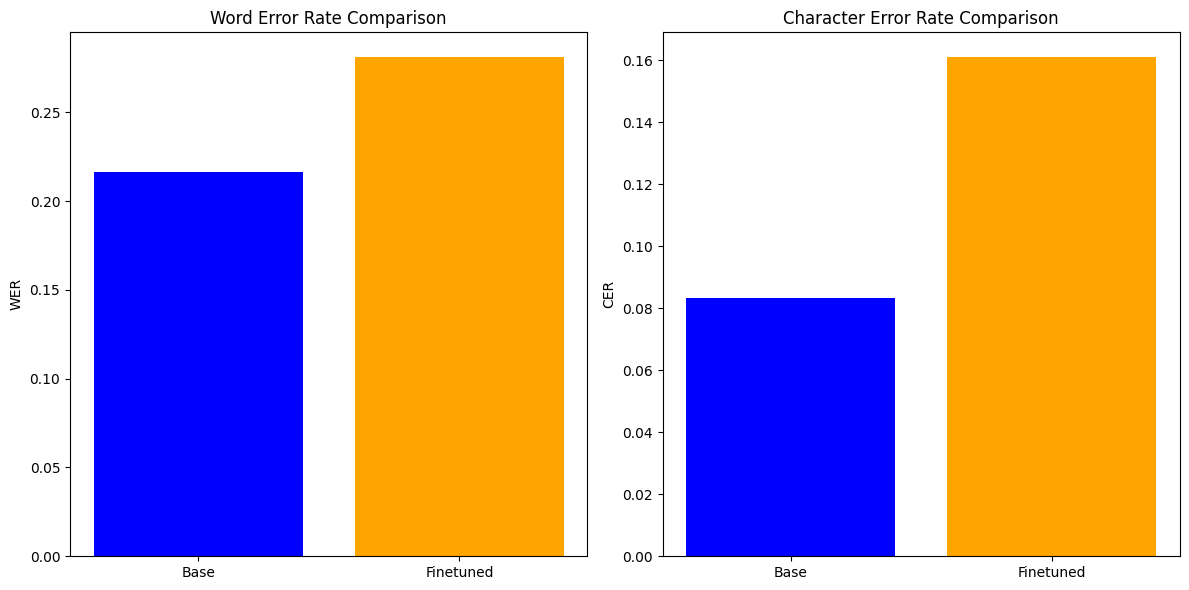

In [12]:
plt.figure(figsize=(12, 6))

# WER Comparison
plt.subplot(1, 2, 1)
plt.bar(["Base", "Finetuned"], [final_metrics["base_wer"], final_metrics["finetuned_wer"]], color=['blue', 'orange'])
plt.title("Word Error Rate Comparison")
plt.ylabel("WER")

# CER Comparison
plt.subplot(1, 2, 2)
plt.bar(["Base", "Finetuned"], [final_metrics["base_cer"], final_metrics["finetuned_cer"]], color=['blue', 'orange'])
plt.title("Character Error Rate Comparison")
plt.ylabel("CER")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/full_comparison.png")
plt.show()



In [13]:
print("✅ Full evaluation complete!")
print(f"📊 Base Model - WER: {final_metrics['base_wer']:.2%}, CER: {final_metrics['base_cer']:.2%}")
print(f"📊 Finetuned Model - WER: {final_metrics['finetuned_wer']:.2%}, CER: {final_metrics['finetuned_cer']:.2%}")
print(f"📁 Results saved to: {OUTPUT_DIR}")

✅ Full evaluation complete!
📊 Base Model - WER: 21.66%, CER: 8.34%
📊 Finetuned Model - WER: 28.10%, CER: 16.10%
📁 Results saved to: /kaggle/working
